In [1]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from source.torch_acc import SLQDataset

from commands.experiment_7_1 import (
    dataset_dir,
    input_shape,
)

save_metadata_dir = "outputs/metadata/experiment_7_*_*/"

from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

# run once
# merged_experiment_metadata = merge_experiment_metadata(save_metadata_dir=save_metadata_dir, glob_path="experiment_7_*/sl_merged_*.csv")

In [28]:
paths = os.path.join(save_metadata_dir, "merged_igsgq_*.csv")
paths = glob(paths)
print(paths)
merged_data = []
for path in paths:
    slq_csv = pd.read_csv(path)
    merged_data.append(slq_csv)
merged_data = pd.concat(merged_data, axis=0)


def minmax_normalize(x: np.ndarray, q=0.99):
    x[x > np.quantile(x, q=q)] = np.quantile(x, q=q)
    return (x - x.min()) / (x.max() - x.min())

['outputs/metadata/experiment_7_2_0/merged_igsgq_metadata.csv']


In [29]:
merged_data.shape

(150000, 31)

In [30]:
merged_data.columns

Index(['time_to_compute', 'batch_index', 'monitored_statistic_change',
       'path_prefix', 'data_path', 'stream_name', 'stream_statistic',
       'alpha_mask_type', 'alpha_mask_value', 'baseline_mask_type',
       'projection_type', 'projection_distribution', 'projection_top_k',
       'projection_index', 'label', 'architecture', 'method', 'output_layer',
       'dataset', 'image_index', 'image_path', 'input_shape', 'num_classes',
       'seed', 'batch_size', 'max_batches', 'min_change', 'metadata_file_path',
       'preds', 'actual_q', 'q'],
      dtype='object')

In [31]:
# set type of merged_data.alpha_mask_value to str
merged_data.alpha_mask_value = merged_data.alpha_mask_value.astype(str)

print(merged_data.q.unique())
print(merged_data.alpha_mask_value.unique())

[10 90 50 70 30]
['0.6' '0.9' '0.4' '0.7' '0.1' '0.2' '0.5' '0.3' '0.8' '0.0']


In [32]:
merged_data_acc = merged_data.groupby(["alpha_mask_value", "q"])["preds"].mean()
merged_data_acc.name = "Accuracy"
merged_data_acc = merged_data_acc.reset_index()

In [33]:
merged_data_acc.groupby("alpha_mask_value")["Accuracy"].mean()

alpha_mask_value
0.0    0.140867
0.1    0.121400
0.2    0.124667
0.3    0.129467
0.4    0.135267
0.5    0.134200
0.6    0.133867
0.7    0.136000
0.8    0.135600
0.9    0.134267
Name: Accuracy, dtype: float64

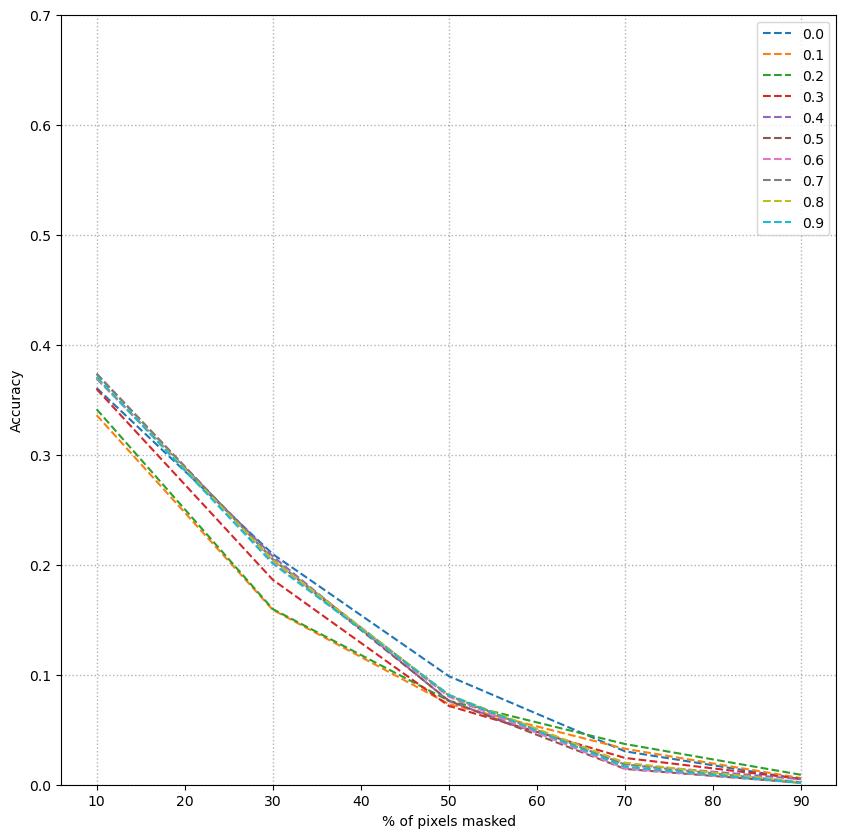

In [34]:
plt.figure(figsize=(10, 10))
# draw vertical lines at ticks
for q in merged_data_acc.q.unique():
    plt.axvline(q, linestyle=":", color="black", alpha=0.3, linewidth=1)
# draw horizontal lines at ticks
plt.ylim(0, 0.7)
ticks = plt.yticks()[0]
for acc in ticks:
    plt.axhline(
        acc,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )

for i, alpha in enumerate(merged_data_acc.alpha_mask_value.unique()):
    merged_data_acc_alpha = merged_data_acc[
        merged_data_acc.alpha_mask_value == alpha
    ]
    plt.plot(
        merged_data_acc_alpha.q,
        merged_data_acc_alpha.Accuracy,
        label=alpha,
        linestyle="-" if "ig" in alpha else "--",
    )

# location top right
plt.legend(loc="upper right")
plt.xlabel("% of pixels masked")
plt.ylabel("Accuracy")
plt.savefig("outputs/figures/accuracy_vs_q.pdf", bbox_inches="tight")

In [5]:
# # copy files
# base_path = "outputs/metadata/experiment_7/"
# paths = "outputs/metadata/experiment_7_1_*/slq*"
# for path in glob(paths):
#     newpath = "_".join(path.split("/")[-2:])
#     newpath = os.path.join(base_path, newpath)
#     # copy file from path to newpath
#     os.system(f"cp {path} {newpath}")